In [21]:
import article
import pandas as pd
from metrics import forecast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
money_control_articles = article.load_articles("data/news/money-control-articles-formatted")
economic_times_articles = article.load_articles("data/news/economic-times-articles-formatted")
live_mint_articles = article.load_articles("data/news/live-mint-articles-formatted")
articles = money_control_articles
articles.extend(economic_times_articles)
articles.extend(live_mint_articles)
len(articles)

6875

In [3]:
content = []
for a in articles:
    if a.cleaned_content == "you can now subscribe to our economic times whatsapp channel":
        continue

    senti = a.sentiment()
    content.append({
        "timestamp": pd.to_datetime(a.market_timestamp),
        "content": a.cleaned_content,
        "pos_senti": senti["pos"],
        "neu_senti": senti["neu"],
        "neg_senti": senti["neg"],
        "compound_senti": senti["compound"],
    })
content = pd.DataFrame(content)
content

,timestamp,content,pos_senti,neu_senti,neg_senti,compound_senti
0,2024-02-20 12:16:00+05:30,e commerce company amazon on tuesday said it h...,0.095,0.894,0.012,0.8575
1,2024-03-28 09:15:00+05:30,reliance power on wednesday said its two subsi...,0.104,0.816,0.081,0.7579
2,2024-04-29 13:27:00+05:30,kundan green energy on monday said it has secu...,0.101,0.899,0.000,0.8807
3,2024-05-01 15:05:00+05:30,eicher motors ltd on wednesday said its arm ve...,0.000,1.000,0.000,0.0000
4,2024-08-05 12:36:00+05:30,the countrys largest airline indigo will launc...,0.015,0.985,0.000,0.2960
...,...,...,...,...,...,...
3032,2024-09-12 12:19:00+05:30,piramal pharma share price has experienced a <...,0.151,0.837,0.012,0.9971
3033,2024-09-24 14:42:00+05:30,shares of popular foundations debuted with a l...,0.157,0.826,0.017,0.9944
3034,2024-10-03 10:02:00+05:30,unilex colours and chemicals ipo listing share...,0.103,0.877,0.020,0.9800
3035,2024-10-03 10:21:00+05:30,stock market today shares of oil gas producers...,0.103,0.788,0.110,-0.7840


In [4]:
content[content["content"].str.contains(r'\bashok\b', case=False, na=False)]

,timestamp,content,pos_senti,neu_senti,neg_senti,compound_senti
77,2024-05-02 11:06:00+05:30,commercial vehicle maker ashok leyland on thur...,0.044,0.956,0.000,0.5267
109,2024-04-18 13:35:00+05:30,commercial vehicle maker ashok leyland ltd on ...,0.109,0.891,0.000,0.8860
163,2024-08-01 13:23:00+05:30,commercial vehicle maker ashok leyland on thur...,0.000,1.000,0.000,0.0000
198,2024-06-26 12:30:00+05:30,hinduja group flagship company ashok leyland h...,0.122,0.878,0.000,0.9705
285,2024-03-05 09:15:00+05:30,the location of the improvised explosive devic...,0.113,0.835,0.052,0.9985
367,2024-06-28 13:26:00+05:30,commercial vehicle maker ashok leyland ltd on ...,0.092,0.908,0.000,0.9100
381,2024-05-27 12:32:00+05:30,commercial vehicle major ashok leyland has an ...,0.153,0.830,0.017,0.9994
530,2024-02-21 12:01:00+05:30,for indian regulators seeking to crack down on...,0.071,0.857,0.073,-0.8214
579,2024-03-20 09:15:00+05:30,hinduja group flagship company ashok leyland o...,0.105,0.895,0.000,0.9565
984,2024-02-28 09:15:00+05:30,mid sized it solutions provider happiest minds...,0.196,0.804,0.000,0.9859


In [5]:
def create_sequences(data, X, time_steps=10):
    assert "Close" in data.columns, "Close not found in data"

    assert "timestamp" in X.columns, "timestamp not found in X"

    d = data[["Close"]]

    no_data_indices = []

    X_seq = []
    for i in X.index:
        end_timestamp = X["timestamp"][i]
        idx = data.index[data['Datetime'] == end_timestamp].tolist()[0]

        sub = d[idx - time_steps:idx]
        if len(sub) == 0:
            no_data_indices.append(i)
            continue

        X_seq.append(sub)
    
    return np.array(X_seq), no_data_indices

In [6]:
stock_data = pd.read_csv("data/stock-prices/ASHOKLEY.NS.csv")

stock_scaler = StandardScaler()
stock_data[["Close"]] = stock_scaler.fit_transform(stock_data[["Close"]])

span_1 = forecast.precise_forecast(stock_data, span=1)
span_2 = forecast.precise_forecast(stock_data, span=2)
span_5 = forecast.precise_forecast(stock_data, span=5)
span_10 = forecast.precise_forecast(stock_data, span=10)
span_30 = forecast.precise_forecast(stock_data, span=30)
stock_data = pd.concat([stock_data, span_1, span_2, span_5, span_10, span_30], axis=1)
stock_data.dropna(inplace=True)
stock_data["Datetime"] = pd.to_datetime(stock_data["Datetime"])
stock_data

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,precise_forecast_1,precise_forecast_2,precise_forecast_5,precise_forecast_10,precise_forecast_30
0,2024-08-12 09:15:00+05:30,249.949997,250.850006,249.899994,0.309872,0,0.0,0.0,0.322326,0.401203,0.388748,0.438566,0.480080
1,2024-08-12 09:16:00+05:30,250.800003,250.949997,250.050003,0.322326,88855,0.0,0.0,0.401203,0.409505,0.421960,0.463474,0.475928
2,2024-08-12 09:17:00+05:30,250.399994,251.350006,250.399994,0.401203,131111,0.0,0.0,0.409505,0.376295,0.488382,0.488382,0.504988
3,2024-08-12 09:18:00+05:30,251.350006,251.500000,250.949997,0.409505,111317,0.0,0.0,0.376295,0.388748,0.492533,0.484231,0.550652
4,2024-08-12 09:19:00+05:30,251.300003,251.600006,251.050003,0.376295,265162,0.0,0.0,0.388748,0.421960,0.463474,0.475928,0.571409
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13059,2024-10-11 14:55:00+05:30,228.460007,228.500000,228.399994,-1.498475,17327,0.0,0.0,-1.496814,-1.510929,-1.525044,-1.535837,-1.569049
13060,2024-10-11 14:56:00+05:30,228.470001,228.490005,228.449997,-1.496814,10908,0.0,0.0,-1.510929,-1.528365,-1.503456,-1.536668,-1.563237
13061,2024-10-11 14:57:00+05:30,228.470001,228.490005,228.300003,-1.510929,15378,0.0,0.0,-1.528365,-1.527535,-1.510099,-1.543311,-1.568218
13062,2024-10-11 14:58:00+05:30,228.320007,228.339996,228.100006,-1.528365,25480,0.0,0.0,-1.527535,-1.525044,-1.521723,-1.550783,-1.571540


In [7]:
data = pd.merge(stock_data, content, left_on='Datetime', right_on='timestamp', how='inner')
data["market_minutes"] = data["timestamp"].apply(lambda x: (x.timestamp() / 60) % 1440 - 225)
data.head()

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,precise_forecast_1,precise_forecast_2,precise_forecast_5,precise_forecast_10,precise_forecast_30,timestamp,content,pos_senti,neu_senti,neg_senti,compound_senti,market_minutes
0,2024-08-12 09:15:00+05:30,249.949997,250.850006,249.899994,0.309872,0,0.0,0.0,0.322326,0.401203,0.388748,0.438566,0.48008,2024-08-12 09:15:00+05:30,chief executives of coforge and persistent sys...,0.062,0.938,0.000,0.8316,0.0
1,2024-08-12 09:15:00+05:30,249.949997,250.850006,249.899994,0.309872,0,0.0,0.0,0.322326,0.401203,0.388748,0.438566,0.48008,2024-08-12 09:15:00+05:30,it firm coforge got a second supplementary not...,0.053,0.932,0.016,0.3919,0.0
2,2024-08-12 09:15:00+05:30,249.949997,250.850006,249.899994,0.309872,0,0.0,0.0,0.322326,0.401203,0.388748,0.438566,0.48008,2024-08-12 09:15:00+05:30,hclsoftware the software business division of ...,0.122,0.867,0.011,0.9628,0.0
3,2024-08-12 09:15:00+05:30,249.949997,250.850006,249.899994,0.309872,0,0.0,0.0,0.322326,0.401203,0.388748,0.438566,0.48008,2024-08-12 09:15:00+05:30,mumbai with it companies gradually coming out ...,0.092,0.901,0.007,0.9325,0.0
4,2024-08-12 09:15:00+05:30,249.949997,250.850006,249.899994,0.309872,0,0.0,0.0,0.322326,0.401203,0.388748,0.438566,0.48008,2024-08-12 09:15:00+05:30,continuing its restructuring spree under new c...,0.121,0.879,0.000,0.9837,0.0


In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [9]:
X = data[["market_minutes", "Close", "Volume", "content", "pos_senti", "neu_senti", "neg_senti", "compound_senti", "timestamp"]]
y = data[["precise_forecast_1", "precise_forecast_2", "precise_forecast_5", "precise_forecast_10", "precise_forecast_30"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1284, 9), (143, 9), (1284, 5), (143, 5))

In [10]:
def max_content_length(data: pd.DataFrame) -> int:
    assert "content" in data.columns, "Content not found in data frame"

    m = 0
    for row in data["content"]:
        m = m if len(row) < m else len(row)
    return m

In [11]:
def neural_net_input(data, X, y):
    stock_seq, no_data_idxs = create_sequences(data, X)
    filtered_X = X[~X.index.isin(no_data_idxs)]
    filtered_y = y[~y.index.isin(no_data_idxs)]
    senti = filtered_X[["pos_senti", "neu_senti", "neg_senti", "compound_senti"]]
    content = filtered_X[["content"]]

    return stock_seq, senti, content, filtered_y

In [12]:
stock_seq_train, senti_train, content_train, labels_train = neural_net_input(stock_data, X_train, y_train)
stock_seq_train.shape, senti_train.shape, content_train.shape, labels_train.shape

((1279, 10, 1), (1279, 4), (1279, 1), (1279, 5))

In [13]:
vectorizer = tf.keras.layers.TextVectorization(
    output_mode="int",
    output_sequence_length=max_content_length(data),
    name="text_vectorizer"
)
vectorizer.adapt(data["content"])
vectorizer.vocabulary_size()

2024-10-14 20:21:03.109230: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-14 20:21:03.109251: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-14 20:21:03.109255: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-14 20:21:03.109483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-14 20:21:03.109498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-14 20:21:03.188559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17986

In [14]:
def add_forecast_layer(layer, span):
    dense1 = tf.keras.layers.Dense(128, activation="relu", name=f"dense{span}_1")(layer)
    dense2 = tf.keras.layers.Dense(32, activation="relu", name=f"dense{span}_2")(dense1)
    output = tf.keras.layers.Dense(1, activation="relu", name=f"output{span}")(dense2)
    return output

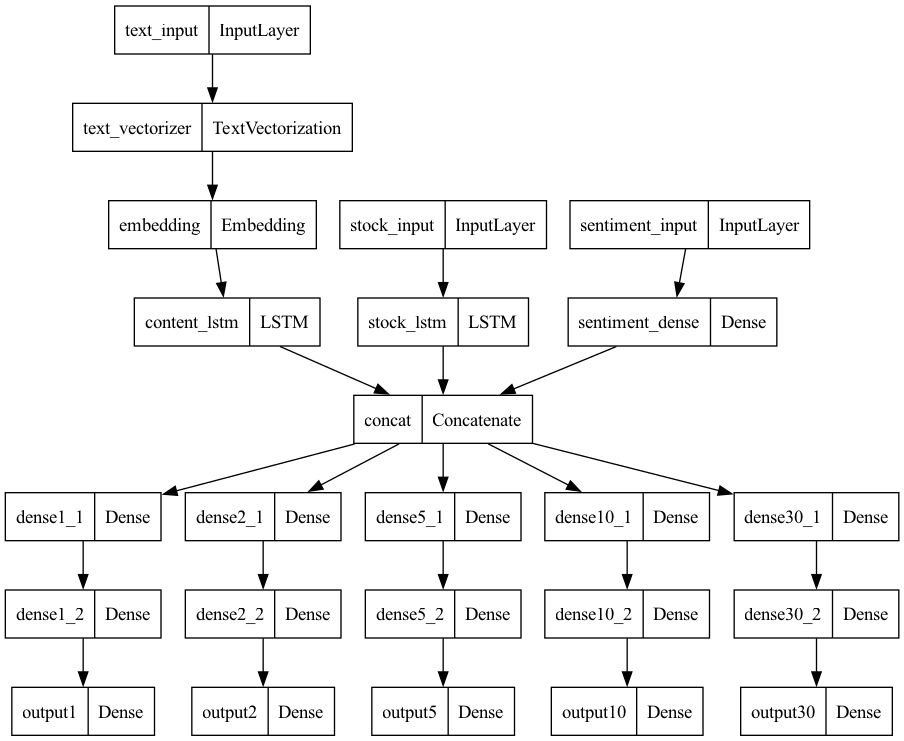

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

stock_lstm_input = tf.keras.layers.Input(shape=(10, 1), name="stock_input")
stock_lstm = tf.keras.layers.LSTM(128, name="stock_lstm")(stock_lstm_input)

sentiment_input = tf.keras.layers.Input(shape=(4, ), name="sentiment_input")
sentiment_dense = tf.keras.layers.Dense(64, activation="relu", name="sentiment_dense")(sentiment_input)

content_input = tf.keras.layers.Input(shape=(1, ), dtype=tf.string, name="text_input")
content_vectorized = vectorizer(content_input)
embedding = tf.keras.layers.Embedding(input_dim=vectorizer.vocabulary_size(), output_dim=128, name="embedding")(content_vectorized)
content_lstm = tf.keras.layers.LSTM(64, name="content_lstm")(embedding)

concat = tf.keras.layers.Concatenate(name="concat")([stock_lstm, sentiment_dense, content_lstm])

output1 = add_forecast_layer(concat, 1)
output2 = add_forecast_layer(concat, 2)
output5 = add_forecast_layer(concat, 5)
output10 = add_forecast_layer(concat, 10)
output30 = add_forecast_layer(concat, 30)

model = tf.keras.Model(
    inputs=[stock_lstm_input, sentiment_input, content_input],
    outputs=[output1, output2, output5, output10, output30]
)

model.compile(
    optimizer="adam", 
    loss="mse"
)

tf.keras.utils.plot_model(model)

In [16]:
model.fit(
    [stock_seq_train, senti_train, content_train],
    labels_train,
    epochs=5,
    validation_split=0.1
)

Epoch 1/5


2024-10-14 20:21:05.345397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-14 20:21:05.724303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-14 20:21:05.726188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-14 20:21:06.583721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-14 20:21:06.615604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.3018 - output1_loss: 0.2320 - output2_loss: 0.1859 - output5_loss: 0.3139 - output10_loss: 0.2688 - output30_loss: 0.3012

2024-10-14 20:21:50.889069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-14 20:21:51.001913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-14 20:21:51.008577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 48s 1s/step - loss: 1.3018 - output1_loss: 0.2320 - output2_loss: 0.1859 - output5_loss: 0.3139 - output10_loss: 0.2688 - output30_loss: 0.3012 - val_loss: 0.4680 - val_output1_loss: 0.0965 - val_output2_loss: 0.1116 - val_output5_loss: 0.0847 - val_output10_loss: 0.1027 - val_output30_loss: 0.0726
Epoch 2/5
36/36 [==============================] - 45s 1s/step - loss: 0.3253 - output1_loss: 0.0698 - output2_loss: 0.0732 - output5_loss: 0.0581 - output10_loss: 0.0647 - output30_loss: 0.0595 - val_loss: 0.3651 - val_output1_loss: 0.0745 - val_output2_loss: 0.0710 - val_output5_loss: 0.0729 - val_output10_loss: 0.0723 - val_output30_loss: 0.0744
Epoch 3/5
36/36 [==============================] - 44s 1s/step - loss: 0.2873 - output1_loss: 0.0610 - output2_loss: 0.0545 - output5_loss: 0.0514 - output10_loss: 0.0560 - output30_loss: 0.0644 - val_loss: 0.3859 - val_output1_loss: 0.0797 - val_output2_loss: 0.0769 - val_output5_loss: 0.0718 - val_output1

In [17]:
stock_seq_test, senti_test, content_test, labels_test = neural_net_input(stock_data, X_test, y_test)
model.evaluate([stock_seq_test, senti_test, content_test], labels_test)

2024-10-14 20:24:48.566486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-14 20:24:48.692256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-14 20:24:48.696713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 332ms/step - loss: 0.3959 - output1_loss: 0.0794 - output2_loss: 0.0847 - output5_loss: 0.0697 - output10_loss: 0.0770 - output30_loss: 0.0851


[0.3958793580532074,
 0.07941263169050217,
 0.08468716591596603,
 0.06966520845890045,
 0.07701840251684189,
 0.08509595692157745]

In [18]:
def visualise_prediction(features, labels, train_sample = 0):
    start = features["timestamp"].iloc[train_sample]
    start_index = stock_data[stock_data["Datetime"] == start].index[0]
    sub = stock_data[["Close"]].iloc[start_index:start_index+31]
    sub = stock_scaler.inverse_transform(sub)
    plt.plot(sub)

    stock_seq, senti, content, labels = neural_net_input(stock_data, features, labels)

    predicted = model.predict([np.array([stock_seq[train_sample]]), np.array([senti.iloc[train_sample].values]), content.iloc[train_sample].values])
    predicted = stock_scaler.inverse_transform(np.reshape(predicted, (1, -1)))
    plt.scatter([1, 2, 5, 10, 30], predicted, c="red")
    plt.legend(["Actual", "Predicted"])

1/1 [==============================] - 0s 161ms/step


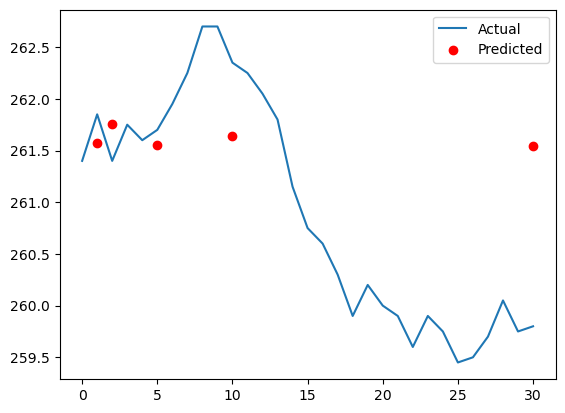

In [20]:
visualise_prediction(X_test, y_test, 0)